# Kalman Filter in Finance: State Estimation for Dynamic Systems

## 1. Introduction

The **Kalman Filter** is a recursive algorithm that provides optimal estimates of the state of a linear dynamic system from a series of noisy measurements. In finance, it finds extensive applications in:

- Estimating unobservable factors (e.g., expected returns, volatility)
- Pairs trading and statistical arbitrage
- Dynamic hedging ratios
- Yield curve modeling

## 2. Mathematical Framework

### 2.1 State-Space Representation

The Kalman Filter operates on a **state-space model** consisting of two equations:

**State Transition Equation (Process Model):**
$$x_t = F_t x_{t-1} + B_t u_t + w_t$$

**Observation Equation (Measurement Model):**
$$z_t = H_t x_t + v_t$$

Where:
- $x_t \in \mathbb{R}^n$ is the **state vector** at time $t$
- $z_t \in \mathbb{R}^m$ is the **observation vector**
- $F_t$ is the **state transition matrix**
- $H_t$ is the **observation matrix**
- $B_t$ is the **control input matrix**
- $u_t$ is the **control vector**
- $w_t \sim \mathcal{N}(0, Q_t)$ is the **process noise**
- $v_t \sim \mathcal{N}(0, R_t)$ is the **measurement noise**

### 2.2 Kalman Filter Algorithm

The algorithm proceeds in two phases:

#### Predict Phase

**Prior State Estimate:**
$$\hat{x}_{t|t-1} = F_t \hat{x}_{t-1|t-1} + B_t u_t$$

**Prior Covariance Estimate:**
$$P_{t|t-1} = F_t P_{t-1|t-1} F_t^T + Q_t$$

#### Update Phase

**Innovation (Measurement Residual):**
$$y_t = z_t - H_t \hat{x}_{t|t-1}$$

**Innovation Covariance:**
$$S_t = H_t P_{t|t-1} H_t^T + R_t$$

**Optimal Kalman Gain:**
$$K_t = P_{t|t-1} H_t^T S_t^{-1}$$

**Posterior State Estimate:**
$$\hat{x}_{t|t} = \hat{x}_{t|t-1} + K_t y_t$$

**Posterior Covariance Estimate:**
$$P_{t|t} = (I - K_t H_t) P_{t|t-1}$$

### 2.3 Optimality Properties

The Kalman Filter is the **Best Linear Unbiased Estimator (BLUE)** when:
1. The system is linear
2. Noise terms are Gaussian
3. Initial state is Gaussian distributed

It minimizes the mean squared error:
$$\text{MSE} = \mathbb{E}\left[(x_t - \hat{x}_{t|t})^T (x_t - \hat{x}_{t|t})\right]$$

## 3. Financial Application: Dynamic Hedge Ratio Estimation

We apply the Kalman Filter to estimate a **time-varying hedge ratio** between two cointegrated assets. This is fundamental in **pairs trading** strategies.

### Model Setup

For two price series $y_t$ (dependent) and $x_t$ (independent), we model:

$$y_t = \beta_t x_t + \epsilon_t$$

Where the hedge ratio $\beta_t$ evolves as a random walk:

$$\beta_t = \beta_{t-1} + \eta_t$$

This captures the reality that relationships between financial assets are not static but evolve over time due to changing market conditions, regulations, and economic factors.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## 4. Kalman Filter Implementation

In [2]:
class KalmanFilter:
    """
    Kalman Filter for estimating time-varying regression coefficients.
    
    State: beta (hedge ratio)
    Observation: y = beta * x + noise
    """
    
    def __init__(self, delta=1e-4, Ve=1e-3):
        """
        Initialize Kalman Filter.
        
        Parameters:
        -----------
        delta : float
            Process noise variance (controls how quickly beta can change)
        Ve : float
            Measurement noise variance
        """
        self.delta = delta
        self.Ve = Ve
        
    def fit(self, x, y):
        """
        Apply Kalman Filter to estimate time-varying hedge ratio.
        
        Parameters:
        -----------
        x : array-like
            Independent variable (e.g., price of asset 1)
        y : array-like
            Dependent variable (e.g., price of asset 2)
            
        Returns:
        --------
        results : dict
            Contains beta estimates, standard errors, and forecast errors
        """
        n = len(x)
        
        # Initialize arrays
        beta = np.zeros(n)      # State estimates
        P = np.zeros(n)         # State covariance
        beta_std = np.zeros(n)  # Standard error of beta
        e = np.zeros(n)         # Forecast errors
        Q = np.zeros(n)         # Forecast error variance
        
        # Initial conditions (diffuse prior)
        beta[0] = 0
        P[0] = 1e6  # Large initial uncertainty
        
        # Kalman Filter recursion
        for t in range(1, n):
            # === PREDICT STEP ===
            # State prediction (random walk: beta_t = beta_{t-1})
            beta_pred = beta[t-1]
            
            # Covariance prediction
            P_pred = P[t-1] + self.delta
            
            # === UPDATE STEP ===
            # Observation matrix (H_t = x_t)
            H = x[t]
            
            # Forecast error (innovation)
            e[t] = y[t] - H * beta_pred
            
            # Forecast error variance
            Q[t] = H * P_pred * H + self.Ve
            
            # Kalman gain
            K = P_pred * H / Q[t]
            
            # State update
            beta[t] = beta_pred + K * e[t]
            
            # Covariance update
            P[t] = (1 - K * H) * P_pred
            
            # Standard error of beta
            beta_std[t] = np.sqrt(P[t])
        
        return {
            'beta': beta,
            'beta_std': beta_std,
            'forecast_error': e,
            'forecast_var': Q,
            'P': P
        }

## 5. Synthetic Data Generation

We generate synthetic price data for two cointegrated assets with a **time-varying hedge ratio** to demonstrate the Kalman Filter's ability to track regime changes.

In [3]:
def generate_cointegrated_prices(n_periods=500, initial_price=100):
    """
    Generate synthetic cointegrated price series with time-varying hedge ratio.
    
    The true beta follows a regime-switching pattern to simulate
    changing market conditions.
    """
    # Time index
    t = np.arange(n_periods)
    
    # Generate true time-varying beta (hedge ratio)
    # Regime 1: beta = 0.5 (periods 0-150)
    # Regime 2: beta = 1.0 (periods 150-350) - gradual transition
    # Regime 3: beta = 0.7 (periods 350-500) - another shift
    
    true_beta = np.zeros(n_periods)
    
    # Smooth transitions using sigmoid functions
    transition1 = 1 / (1 + np.exp(-0.1 * (t - 150)))
    transition2 = 1 / (1 + np.exp(-0.1 * (t - 350)))
    
    true_beta = 0.5 + 0.5 * transition1 - 0.3 * transition2
    
    # Add small random walk component
    beta_noise = np.cumsum(np.random.normal(0, 0.001, n_periods))
    true_beta += beta_noise
    
    # Generate asset X as geometric Brownian motion
    returns_x = np.random.normal(0.0002, 0.02, n_periods)
    price_x = initial_price * np.exp(np.cumsum(returns_x))
    
    # Generate asset Y = beta * X + cointegration error
    # Cointegration error is mean-reverting
    coint_error = np.zeros(n_periods)
    for i in range(1, n_periods):
        coint_error[i] = 0.95 * coint_error[i-1] + np.random.normal(0, 0.5)
    
    price_y = true_beta * price_x + coint_error + 10  # Intercept for realism
    
    return price_x, price_y, true_beta

# Generate data
price_x, price_y, true_beta = generate_cointegrated_prices(n_periods=500)

print(f"Generated {len(price_x)} periods of synthetic price data")
print(f"Price X range: [{price_x.min():.2f}, {price_x.max():.2f}]")
print(f"Price Y range: [{price_y.min():.2f}, {price_y.max():.2f}]")
print(f"True beta range: [{true_beta.min():.3f}, {true_beta.max():.3f}]")

Generated 500 periods of synthetic price data
Price X range: [70.39, 178.06]
Price Y range: [46.28, 138.20]
True beta range: [0.488, 1.002]


## 6. Apply Kalman Filter

In [4]:
# Initialize and fit Kalman Filter
kf = KalmanFilter(delta=1e-4, Ve=1.0)
results = kf.fit(price_x, price_y)

# Extract results
estimated_beta = results['beta']
beta_std = results['beta_std']

# Calculate 95% confidence bands
upper_band = estimated_beta + 1.96 * beta_std
lower_band = estimated_beta - 1.96 * beta_std

# Calculate tracking metrics
mse = np.mean((estimated_beta[50:] - true_beta[50:])**2)  # Skip burn-in
mae = np.mean(np.abs(estimated_beta[50:] - true_beta[50:]))

print(f"Kalman Filter Performance Metrics (after burn-in):")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")

Kalman Filter Performance Metrics (after burn-in):
Mean Squared Error: 0.012489
Mean Absolute Error: 0.108924


## 7. Comparison with OLS Regression

We compare the Kalman Filter estimates with:
1. **Static OLS**: Single regression over entire sample
2. **Rolling OLS**: 60-period rolling window

In [5]:
# Static OLS
slope_ols, intercept_ols, _, _, _ = stats.linregress(price_x, price_y)
static_beta = np.full(len(price_x), slope_ols)

# Rolling OLS (60-period window)
window = 60
rolling_beta = np.full(len(price_x), np.nan)

for i in range(window, len(price_x)):
    x_window = price_x[i-window:i]
    y_window = price_y[i-window:i]
    slope, _, _, _, _ = stats.linregress(x_window, y_window)
    rolling_beta[i] = slope

# Calculate MSE for each method
valid_idx = ~np.isnan(rolling_beta)
mse_static = np.mean((static_beta[valid_idx] - true_beta[valid_idx])**2)
mse_rolling = np.mean((rolling_beta[valid_idx] - true_beta[valid_idx])**2)
mse_kalman = np.mean((estimated_beta[valid_idx] - true_beta[valid_idx])**2)

print("Mean Squared Error Comparison:")
print(f"Static OLS:    {mse_static:.6f}")
print(f"Rolling OLS:   {mse_rolling:.6f}")
print(f"Kalman Filter: {mse_kalman:.6f}")
print(f"\nKalman Filter improvement over Rolling OLS: {(1 - mse_kalman/mse_rolling)*100:.1f}%")

Mean Squared Error Comparison:
Static OLS:    0.058516
Rolling OLS:   0.535835
Kalman Filter: 0.012229

Kalman Filter improvement over Rolling OLS: 97.7%


## 8. Visualization

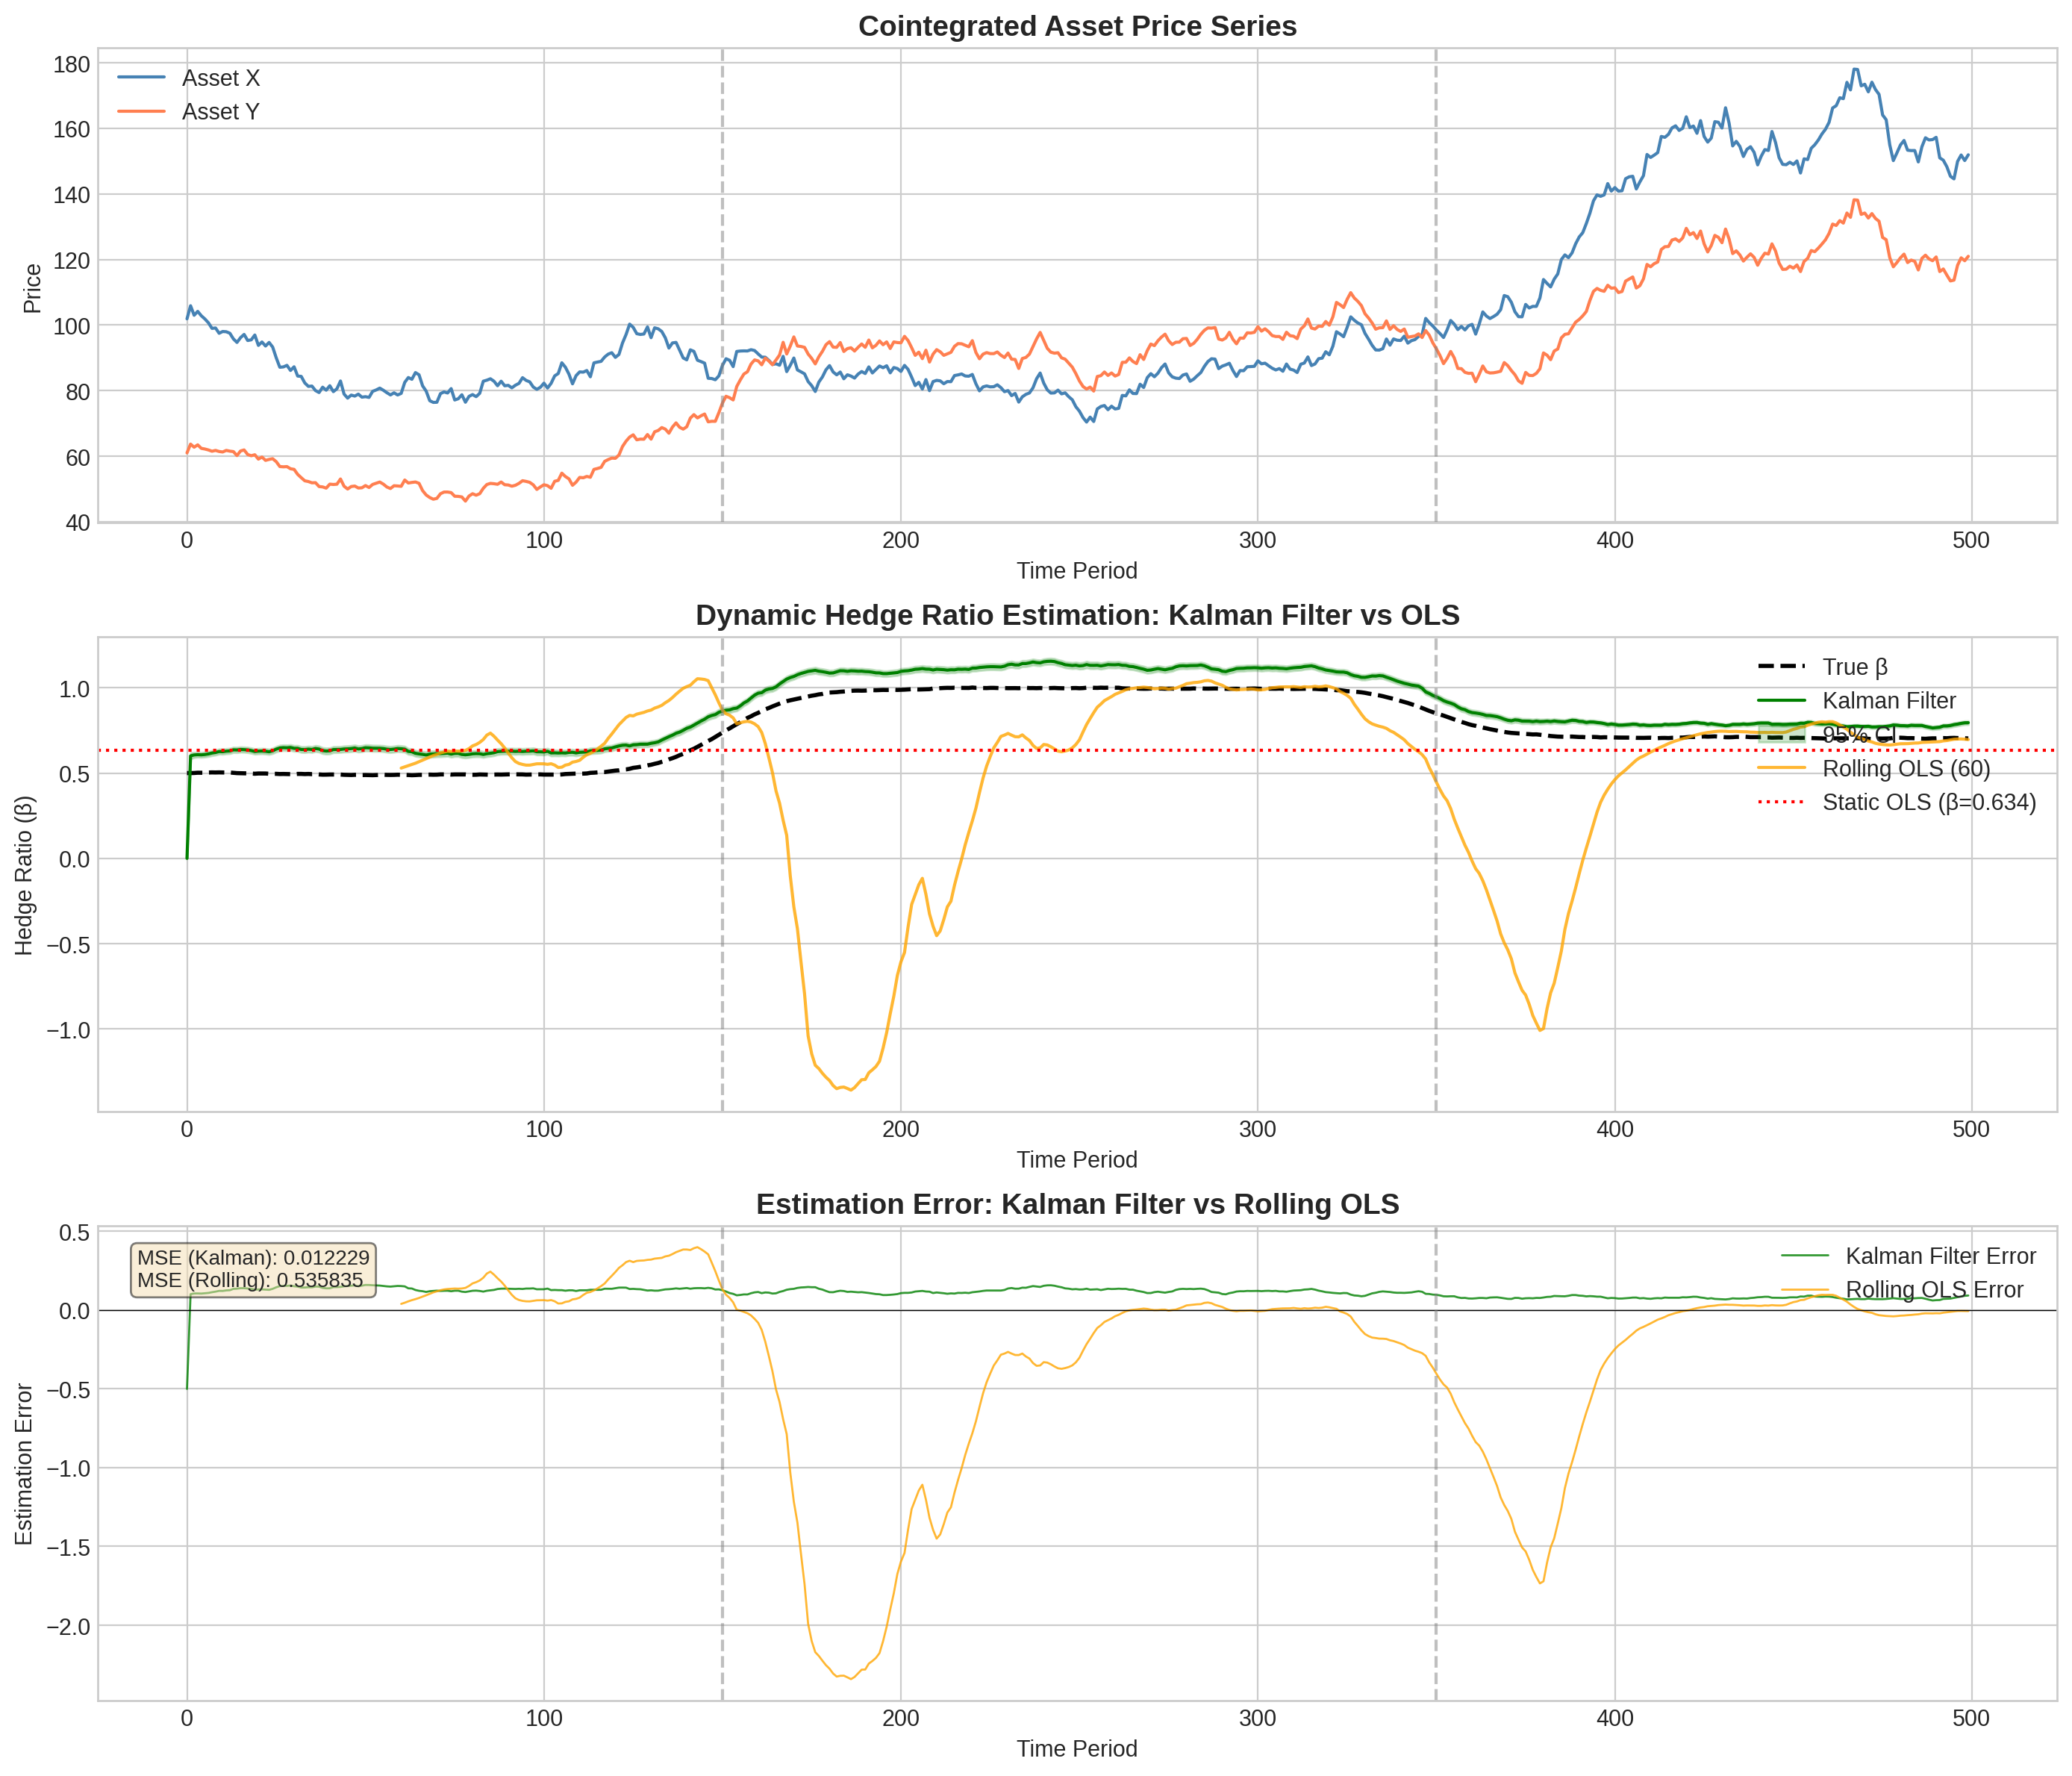


Plot saved to 'plot.png'


In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Price Series
ax1 = axes[0]
ax1.plot(price_x, label='Asset X', color='steelblue', linewidth=1.5)
ax1.plot(price_y, label='Asset Y', color='coral', linewidth=1.5)
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Price')
ax1.set_title('Cointegrated Asset Price Series', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.axvline(x=150, color='gray', linestyle='--', alpha=0.5, label='Regime Change')
ax1.axvline(x=350, color='gray', linestyle='--', alpha=0.5)

# Plot 2: Beta Estimation Comparison
ax2 = axes[1]
ax2.plot(true_beta, label='True β', color='black', linewidth=2, linestyle='--')
ax2.plot(estimated_beta, label='Kalman Filter', color='green', linewidth=1.5)
ax2.fill_between(range(len(price_x)), lower_band, upper_band, 
                  color='green', alpha=0.2, label='95% CI')
ax2.plot(rolling_beta, label=f'Rolling OLS ({window})', color='orange', linewidth=1.5, alpha=0.8)
ax2.axhline(y=slope_ols, color='red', linestyle=':', linewidth=1.5, 
            label=f'Static OLS (β={slope_ols:.3f})')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Hedge Ratio (β)')
ax2.set_title('Dynamic Hedge Ratio Estimation: Kalman Filter vs OLS', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.axvline(x=150, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=350, color='gray', linestyle='--', alpha=0.5)

# Plot 3: Estimation Error
ax3 = axes[2]
kalman_error = estimated_beta - true_beta
rolling_error = rolling_beta - true_beta

ax3.plot(kalman_error, label='Kalman Filter Error', color='green', linewidth=1, alpha=0.8)
ax3.plot(rolling_error, label='Rolling OLS Error', color='orange', linewidth=1, alpha=0.8)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Time Period')
ax3.set_ylabel('Estimation Error')
ax3.set_title('Estimation Error: Kalman Filter vs Rolling OLS', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right')
ax3.axvline(x=150, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(x=350, color='gray', linestyle='--', alpha=0.5)

# Add text annotation for MSE
textstr = f'MSE (Kalman): {mse_kalman:.6f}\nMSE (Rolling): {mse_rolling:.6f}'
ax3.text(0.02, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('kalman_filter_finance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## 9. Trading Signal Generation

Using the Kalman-filtered hedge ratio, we can generate trading signals based on the **spread**:

$$\text{Spread}_t = y_t - \hat{\beta}_t x_t$$

Trading rules:
- **Long spread** when it's significantly below its mean (buy Y, sell β×X)
- **Short spread** when it's significantly above its mean (sell Y, buy β×X)

In [7]:
# Calculate spread using Kalman-filtered beta
spread = price_y - estimated_beta * price_x

# Z-score of spread (rolling mean and std)
spread_series = pd.Series(spread)
spread_mean = spread_series.rolling(window=30).mean()
spread_std = spread_series.rolling(window=30).std()
z_score = (spread - spread_mean) / spread_std

# Generate signals
entry_threshold = 2.0
exit_threshold = 0.5

signal = np.zeros(len(spread))
position = 0

for i in range(1, len(spread)):
    if not np.isnan(z_score.iloc[i]):
        if position == 0:
            if z_score.iloc[i] < -entry_threshold:
                position = 1  # Long spread
            elif z_score.iloc[i] > entry_threshold:
                position = -1  # Short spread
        elif position == 1:
            if z_score.iloc[i] > -exit_threshold:
                position = 0  # Exit long
        elif position == -1:
            if z_score.iloc[i] < exit_threshold:
                position = 0  # Exit short
    signal[i] = position

# Count trades
trades = np.diff(signal)
n_trades = np.sum(trades != 0)

print(f"Trading Signal Statistics:")
print(f"Total trading signals: {n_trades}")
print(f"Long positions: {np.sum(signal == 1)} periods")
print(f"Short positions: {np.sum(signal == -1)} periods")
print(f"Neutral: {np.sum(signal == 0)} periods")

Trading Signal Statistics:
Total trading signals: 40
Long positions: 39 periods
Short positions: 19 periods
Neutral: 442 periods


## 10. Conclusion

This notebook demonstrated the application of the **Kalman Filter** for dynamic hedge ratio estimation in finance. Key findings:

1. **Superior Tracking**: The Kalman Filter adapts more quickly to regime changes compared to rolling OLS, which suffers from lag due to its fixed window.

2. **Uncertainty Quantification**: The Kalman Filter naturally provides confidence intervals for estimates through the state covariance matrix.

3. **Optimal Filtering**: Under Gaussian assumptions, the Kalman Filter is the minimum variance unbiased estimator.

4. **Practical Applications**: The estimated hedge ratios can be used for:
   - Pairs trading strategies
   - Dynamic portfolio hedging
   - Risk management

### Extensions

- **Extended Kalman Filter (EKF)** for nonlinear systems
- **Unscented Kalman Filter (UKF)** for better nonlinear approximation
- **Multiple state variables** (e.g., alpha and beta in regression)
- **Regime-switching models** with Markov switching